In [22]:
import matplotlib.pyplot as plt
import matplotlib

import pandas as pd
import numpy as np
from typing import List
from typing import Union
from typing import Iterator
from typing import Optional
import re
import numpy as np
from functools import reduce
import ast
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from random import Random
import threading
from tqdm import tqdm

import onnx
import tvm
from tvm.relay.frontend import onnx as ox
from tvm import relay
from tvm.autotvm.graph_tuner.utils import expr2graph

import torch
from torch.utils.data import DataLoader, Dataset, Sampler
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim import Adam, Optimizer
import torch.nn.functional as F


op_names = [
"torch.Linear", "core.Reshape", "core.ReplicatePad ", "core.ReLU", 
"core.ExpandLast1", "core.Sub", "core.NCHWConv2d", "core.Tril", "core.Mul", 
"core.Clip", "core.Atan", "core.Squeeze", "core.ReduceMax", "core.Or", 
"core.NearestInterp", "core.ExpandLast4", "core.Conv1d", "core.Min", 
"None", "core.Max", "Concat ", "core.Transpose", "core.Round", "core.ArgMax", 
"core.Where", "core.GELU", "core.AvgPool2d", "core.Ceil", "core.BatchNorm2d", 
"Constant", "core.LeakyReLU", "core.Sigmoid", "core.ReduceMean", "core.Add", 
"core.Neg", "core.Triu", "core.TrilinearInterp", "core.Floor", "core.ArgMin", 
"core.Div", "core.Xor", "core.Slice ", "core.BilinearInterp", "core.LinearInterp", 
"core.Abs", "core.Equal", "core.ConstPad ", "torch.Flatten", "core.And", "Input", 
"Cast ", "torch.TorchReduceSum", "core.Cos", "core.ExpandLast2", "core.Softmax", 
"core.Sin", "core.MaxPool2d", "core.BicubicInterp", "core.Less", "core.PReLU", 
"core.ExpandLast3", "core.ReduceMin", "core.ReflectPad ", "core.Tan", "core.Greater",
"torch.PTMatMul"
]


data_type_names = [
    "i64", "i32", "b", "i8", "f64", "i16", "Unknow", "f32", "f16", "u8"
]

vocab = {op:  idx for idx, op in enumerate(op_names)}
op_vocab = {op: idx for idx, op in enumerate(op_names)}

# Load the dataset from the JSON file
json_filename = 'train_3000_3000.json'
with open(json_filename, 'r') as jsonfile:
    loaded_dataset_dicts = json.load(jsonfile)

# Extract the lists from the loaded dataset
node_info_set = [item['node_info'] for item in loaded_dataset_dicts]
edge_info_set = [item['edge_info'] for item in loaded_dataset_dicts]
graph_info_set = [item['graph_info'] for item in loaded_dataset_dicts]
result_set = [item['result'] for item in loaded_dataset_dicts]
count_result = 0
count_true_result = 0
for result in result_set:
    if result == 1:
        count_true_result += 1
    count_result += 1
print("在",count_result,"中有",count_true_result,"个触发bug")

def onek_encoding_unk(value, choices: List):
    encoding = [0] * (len(choices) + 1)
    index = choices.index(value) if value in choices else -1
    encoding[index] = 1

    return encoding

def node_features(node_info:list):
    features = onek_encoding_unk(node_info[1], op_names) 
    features.append(node_info[2])
    return features

def edge_features(edge_info:list):
    features = []
    for i in range(5):
        features.append(edge_info[2][i])
    tmp_list = onek_encoding_unk(edge_info[3], data_type_names)
    for i in range(len(tmp_list)):
        features.append(tmp_list[i])
    return features

# 初始化模型的参数
def initialize_weights(model:nn.Module)->None:
    for param in model.parameters():
        if param.dim() == 1:
            nn.init.constant_(param, 0)
        else:
            nn.init.xavier_normal_(param)

def index_select_ND(source: torch.Tensor, index: torch.Tensor) -> torch.Tensor:
    """
    Selects the message features from source corresponding to the node or edge indices in index.
    """
    index_size = index.size()  # (num_nodes/num_edges, max_num_edges)
    suffix_dim = source.size()[1:]  # (hidden_size,) 也就是source中除了第一个维度之外的所有维度的大小
    final_size = index_size + suffix_dim  # (num_nodess/num_edges, max_num_edges, hidden_size)
    target = source.index_select(dim=0, index=index.view(-1))  # (num_nodes/num_edges * max_num_edges, hidden_size)
    target = target.view(final_size)  # (num_nodes/num_edges, max_num_edges, hidden_size)
    return target

class TrainArgs:
    no_cuda = False
    gpu = 0
    num_workers = 16
    batch_size = 16
    dataset_type = 'classification'
    task_names = []
    num_tasks = 1
    seed = 0
    hidden_size = 400
    bias = False
    depth = 3
    dropout = 0.3
    undirected = False
    aggregation = 'norm'
    aggregation_norm = 200
    cuda = True
    ffn_num_layers = 3
    ffn_hidden_size = 400
    init_lr = 1e-4
    max_lr = 1e-3
    final_lr = 1e-4
    num_lrs = 1
    warmup_epochs = 2.0
    epochs = 100

    @property
    def device(self) -> torch.device:
        """The :code:`torch.device` on which to load and process data and models."""
        if not self.cuda:
            return torch.device('cpu')

        return torch.device('cuda', self.gpu)

    @device.setter
    def device(self, device: torch.device) -> None:
        self.cuda = device.type == 'cuda'
        self.gpu = device.index

    @property
    def cuda(self) -> bool:
        """Whether to use CUDA (i.e., GPUs) or not."""
        return not self.no_cuda and torch.cuda.is_available()

    @cuda.setter
    def cuda(self, cuda: bool) -> None:
        self.no_cuda = not cuda
        
args = TrainArgs()

node_info = node_info_set[0]
edge_info = edge_info_set[0]
result = result_set[0]

NODE_FDIM = len(node_features(node_info[0]))
EDGE_FDIM = len(edge_features(edge_info[0])) + NODE_FDIM
print(NODE_FDIM, EDGE_FDIM)

def get_node_fdim():
    return NODE_FDIM

def get_edge_fdim():
    return EDGE_FDIM

def graph_info_dim():
    # 假设 graph_info 的前两个元素是数字
    base_dim = 2
    op_vector_dim = len(op_vocab) + 1  # 加1是因为有一个额外的类别表示未知的算子
    # category_vector_dim = len(category_vocab) + 1  # 加1是因为有一个额外的类别表示未知的类别
    return base_dim + op_vector_dim 

class CompGraphDatapoint:
    def __init__(self,
                 node_info: list,
                 edge_info: list,
                 graph_info: list,
                 result: int,
                 op_vocab: dict,
                 ):
        self.node_info = node_info
        self.edge_info = edge_info
        self.graph_info = self.encode_graph_info(graph_info, op_vocab)
        self.result = result

    def encode_graph_info(self, graph_info, op_vocab):
        # 对算子进行编码
        ops = graph_info[2]
        op_indices = [op_vocab.get(op, len(op_vocab)) for op in ops]

        # 对算子类别进行编码
        # categories = graph_info[3]
        # category_indices = [category_vocab.get(category, len(category_vocab)) for category in categories]

        # 创建One-Hot编码向量
        op_vector = [0] * (len(op_vocab) + 1)
        for idx in op_indices:
            op_vector[idx] = 1

        # category_vector = [0] * (len(category_vocab) + 1)
        # for idx in category_indices:
        #     category_vector[idx] = 1

        # 合并编码后的向量
        encoded_graph_info = graph_info[:2] + op_vector 
        return encoded_graph_info

class CompGraphDataset(Dataset):
    def __init__(self, data:List[CompGraphDatapoint]):
        self._data = data
        self._scaler = None
        self._batch_graph = []
        self._random = Random()
    
    def AllCompGraphs(self):
        return [(g.node_info, g.edge_info, g.result) for g in self._data]
    
    def __len__(self):
        return len(self._data)
    
    def __getitem__(self, item):
        return self._data[item]
    
    def results(self):
        return [d.result for d in self._data]
    
    def batch_graph(self):   
        for d in self._data:
            compgraph = CompGraph(d.node_info, d.edge_info)
            self._batch_graph.append(compgraph)
        return self._batch_graph

class CompGraph:
    def __init__(self, node_info:list, edge_info:list):
        self.n_nodes = 0 # number of nodes
        self.n_edges = 0 # number of edges
        self.f_nodes = [] # mapping from node index to node features
        self.f_edges = [] # mapping from edge index to concat(in_node, edge) features
        self.a2b = [] # mapping from node index to incoming edge indices 这里是为了将输入到这个节点的边的信息汇聚过来
        self.b2a = [] # mapping from edge index to the incoming node index

        # self.node_id_to_index = {node_info[i][0]: i for i in range(len(node_info))}

        # # get node features
        # self.f_nodes = [node_features(node) for node in node_info]
        # self.n_nodes = len(self.f_nodes)

        # # initialize node to edge mapping for each ndoe
        # for _ in range(self.n_nodes):
        #     self.a2b.append([])

        # for edge in edge_info:
        #     f_edge = edge_features(edge)
        #     # 确保 self.f_nodes[edge[0]] 是一个张量
        #     # if isinstance(self.f_nodes[edge[0]], list):
        #     #     self.f_nodes[edge[0]] = torch.tensor(self.f_nodes[edge[0]])

        #     # # 确保 f_edge 是一个张量
        #     # if isinstance(f_edge, list):
        #     #     f_edge = torch.tensor(f_edge)
        #     # self.f_edges.append(torch.cat([self.f_nodes[edge[0]], f_edge], dim=0)) # 这里将边的特征更新为原始的边特征与源点节点特征的拼接concat(in_node_info, edge_info)
        #     self.f_edges.append(self.f_nodes[edge[0]] + f_edge)
        #     self.a2b[edge[1]].append(edge[4])
        #     self.b2a.append(edge[0])
        # self.n_edges = len(self.f_edges)

        # Build node features and initialize a2b mapping
        self.f_nodes = [node_features(node) for node in node_info]
        self.n_nodes = len(self.f_nodes)
        for _ in range(self.n_nodes):
            self.a2b.append([])

        # Create a mapping from old node identifiers to new indices
        node_id_to_index = {node_info[i][0]: i for i in range(len(node_info))}

        # Update edge_info to ensure source and target node identifiers match their index
        for edge in edge_info:
            source_node_id = edge[0]
            target_node_id = edge[1]

            # Update source and target node identifiers to match their indices
            source_node_index = node_id_to_index[source_node_id]
            target_node_index = node_id_to_index[target_node_id]
            edge[0] = source_node_index
            edge[1] = target_node_index

            # Update f_edges with concatenated features
            self.f_edges.append(self.f_nodes[source_node_index] + edge_features(edge))

            # Update a2b mapping using target node index
            self.a2b[target_node_index].append(edge[4])
            self.b2a.append(source_node_index)

        self.n_edges = len(self.f_edges)

    def get_components(self):
        return self.f_nodes, self.f_edges, self.a2b, self.b2a
    
class BatchCompGraph:
    '''
    处理一个batch的计算图，加速
    '''
    def __init__(self, comp_graphs:List[CompGraph]):
        self.node_fdim = get_node_fdim()
        self.edge_fdim = get_edge_fdim()
        self.compgraph_count = len(comp_graphs)
        # start n_nodes and n_edges at 1 b/c zero padding
        self.n_nodes = 1
        self.n_edges = 1
        self.a_scope = []   # list of tuples indicating (start_node_index, num_nodes) for each graph
        self.b_scope = []   # list of tuples indicating (start_edge_index, num_edges) for each graph

        # all start with zero padding so that indexing with zero padding returns zeros
        f_nodes = [[0] * self.node_fdim]  # node features
        f_edges = [[0] * self.edge_fdim]  # combined node/edge features
        a2b = [[]]  # mapping from node index to incoming edge indices
        b2a = [0]  # mapping from edge index to the index of the node the edge is coming from

        for comp_graph in comp_graphs:
            f_nodes.extend(comp_graph.f_nodes)
            f_edges.extend(comp_graph.f_edges)

            for a in range(comp_graph.n_nodes):
                a2b.append([b + self.n_edges for b in comp_graph.a2b[a]])

            for b in range(comp_graph.n_edges):
                b2a.append(self.n_nodes + comp_graph.b2a[b])

            self.a_scope.append((self.n_nodes, comp_graph.n_nodes))
            self.b_scope.append((self.n_edges, comp_graph.n_edges))
            self.n_nodes += comp_graph.n_nodes
            self.n_edges += comp_graph.n_edges

        self.max_num_edges = max(1, max(len(in_bonds) for in_bonds in a2b))  # max with 1 to fix a crash in case of
        # all single-heavy-node graph

        self.f_nodes = torch.FloatTensor(f_nodes)
        self.f_edges = torch.FloatTensor(f_edges)
        self.a2b = torch.LongTensor([a2b[a] + [0] * (self.max_num_edges - len(a2b[a])) for a in range(self.n_nodes)])
        self.b2a = torch.LongTensor(b2a)
        self.b2b = None  # try to avoid computing b2b b/c O(n_nodes^3)
        self.a2a = None  # only needed if using node messages

    def get_components(self):
        return self.f_nodes, self.f_edges, self.a2b, self.b2a, self.a_scope, self.b_scope

# MPNEncodr类，负责计算图的编码过程，首先将每条边转换为一个隐藏状态，然后通过多次message_passing来更新这些隐藏状态
# 用来模型信息在图中的传递
'''
要训练的权重参数如下：
W_i: 用于初始边特征到隐藏状态的转换
W_h: 在每次message passing迭代中用于更新隐藏状态的权重
W_o: 将最终的节点表示和原始的节点表示拼接后，用于生成最终的原子隐藏状态
'''
# 消息传递的逻辑：边的特征是原始边特征与源点特征的拼接，每一次传递过程中，边的特征会传递给终点节点
class MPNEncoder(nn.Module):
    def __init__(self, args, node_fdim, edge_fdim):
        super(MPNEncoder, self).__init__()
        self.node_fdim = node_fdim
        self.edge_fdim = edge_fdim  # 这里的edge_fdim是原始的edge_fdim + node_fdim
        self.hidden_size = args.hidden_size
        self.bias = args.bias
        self.depth = args.depth
        self.dropout = args.dropout
        self.layers_per_message = 1
        self.undirected = False
        self.node_messages = False
        self.device = args.device
        self.aggregation = args.aggregation
        self.aggregation_norm = args.aggregation_norm

        self.dropout_layer = nn.Dropout(p=self.dropout)
        self.act_func = nn.ReLU()
        self.cached_zero_vector = nn.Parameter(torch.zeros(self.hidden_size), requires_grad=False)

        # Input
        input_dim = self.edge_fdim
        self.W_i = nn.Linear(input_dim, self.hidden_size)
        w_h_input_size = self.hidden_size

        # Shared weight matrix across depths (default)
        self.W_h = nn.Linear(w_h_input_size, self.hidden_size)
        self.W_o = nn.Linear(self.node_fdim + self.hidden_size, self.hidden_size)
    
    def forward(self, batch_graph, encoded_graph_infos):
        '''
        Encodes a batch of computation graphs
        '''
        # print("Encoder的forward函数收到的输入：", comp_graph.compgraph_count)
        # 是图神经网络中消息传递过程的核心
        # 步骤：
        # 1. 初始特征转换，首先，利用线性层W_i将边的特征f_edges转换为初始的隐藏状态。
        # 2. 消息传递，包括多轮消息传递。每一轮包括：
        # 使用index_select_ND函数和a2b映射，从当前的边消息中收集每个节点的邻居边消息。
        # 对于每个节点，聚合其所有输入边的消息，形成该节点的聚合消息。
        f_nodes, f_edges, a2b, b2a, a_scope, b_scope = batch_graph.get_components()
        f_nodes, f_edges, a2b, b2a, = f_nodes.to(self.device), f_edges.to(self.device), a2b.to(self.device), b2a.to(self.device)
        self.W_i = self.W_i.to(self.device)
        self.W_h = self.W_h.to(self.device)
        self.W_o = self.W_o.to(self.device)
        
        input = self.W_i(f_edges)   # num_edges * hidden_size
        # print('input size: ', input.size()) 
        message = self.act_func(input)  # num_edges * hidden_size

        # message passing
        for depth in range(self.depth - 1):
            # b2a: num_edges * max_num_nodes
            # a2b: num_nodes * max_num_edges
            # 其中，max_num_nodes是固定为1的，因为每一条边只能有一个源点
            # 但是，max_num_edges不固定，因为一个节点可能会有多条边的输入
            nei_a_message = index_select_ND(message, a2b) # num_nodes * max_num_bonds * hidden_size
            # print('nei_a_message.size: ', nei_a_message.size())
            a_message = nei_a_message.sum(dim = 1)  # num_nodes * hiddden_size
            # print('a_message.size: ', a_message.size())
            # 这里就是将，边e的源点a的信息直接作为e的新的特征。
            message = a_message[b2a] # num_edges * hidden_size !!!!!!!!!!!!!!!!!!

            # message = message.sum(dim = 1)
            
            # print('message.size1: ', message.size())
            message = self.W_h(message)
            # print('message.size2: ', message.size())
            message = self.act_func(input + message) # num_edges * hidden_size
            message = self.dropout_layer(message)

        a2x = a2b
        nei_a_message  = index_select_ND(message, a2x)  # num_nodes * max_num * hidden_size
        a_message = nei_a_message.sum(dim = 1)  # num_nodes * hidden_size
        a_input = torch.cat([f_nodes, a_message], dim = 1)  # num_nodes * (node_fdim + hidden_size)
        node_hiddens = self.act_func(self.W_o(a_input)) # num_nodes * hidden_size
        node_hiddens = self.dropout_layer(node_hiddens) # num_nodes * hidden_size
        
        # readout
        graph_vecs = []
        for i, (a_start, a_size) in enumerate(a_scope):
            if a_size == 0:
                graph_vecs.append(self.cached_zero_vector)
            else:
                # print('graph_vecs_size: ', len(graph_vecs))
                cur_hiddens = node_hiddens.narrow(0, a_start, a_size)
                # print('cur_hiddens_size: ', cur_hiddens.size())
                graph_vector = cur_hiddens
                if self.aggregation == 'mean':
                    graph_vector = graph_vector.sum(dim = 0) / a_size
                elif self.aggregation == 'sum':
                    graph_vector = graph_vector.sum(dim = 0)
                elif self.aggregation == 'norm':
                    graph_vector = graph_vector.sum(dim = 0) / self.aggregation_norm
            graph_vecs.append(graph_vector)
        graph_vecs = torch.stack(graph_vecs, dim = 0)
        # print("Encoder's output'size: ", graph_vecs.size())
        encoded_graph_infos_tensor = torch.tensor(encoded_graph_infos, dtype=torch.float).to(self.device)
        graph_vecs = torch.cat([graph_vecs, encoded_graph_infos_tensor], dim=1)
        return graph_vecs

class MPN(nn.Module):
    def __init__(self, args, node_fdim=None, edge_fdim=None):
        super(MPN, self).__init__()
        self.node_fdim = node_fdim or get_node_fdim()
        self.edge_fdim = edge_fdim or get_edge_fdim()
        self.device = args.device
        self.encoder = MPNEncoder(args, self.node_fdim, self.edge_fdim)

    def forward(self, batch_comp_graph, encoded_graph_infos):
        if type(batch_comp_graph) != BatchCompGraph:
            batch_comp_graph = BatchCompGraph(batch_comp_graph)
        return self.encoder(batch_comp_graph, encoded_graph_infos)
    
# mpnencoder = MPNEncoder(args, len(node_features(node_info[0])), len(edge_features(edge_info[0]))+len(node_features(node_info[0])))
# graph_vecs = mpnencoder.forward(batch_graph)  
        
class Comp_Model(nn.Module):
    def __init__(self, args, graph_info_dim):
        super(Comp_Model, self).__init__()
        self.classification = args.dataset_type == 'classification'
        self.output_size = args.num_tasks
        if self.classification:
            self.sigmoid = nn.Sigmoid()
        self.create_encoder(args)
        self.create_ffn(args, graph_info_dim)
        initialize_weights(self)

    def create_encoder(self, args):
        self.encoder = MPN(args)

    def create_ffn(self, args, graph_info_dim):
        first_linear_dim = args.hidden_size + graph_info_dim  # 加上 encoded_graph_info 的长度
        dropout = nn.Dropout(args.dropout)
        activation = nn.ReLU()
        ffn = [dropout, nn.Linear(first_linear_dim, args.ffn_hidden_size)]
        for _ in range(args.ffn_num_layers - 2):
            ffn.extend([activation, dropout, nn.Linear(args.ffn_hidden_size, args.ffn_hidden_size)])
        ffn.extend([activation, dropout, nn.Linear(args.ffn_hidden_size, self.output_size)])
        self.ffn = nn.Sequential(*ffn)

    def forward(self, batch, encoded_graph_infos):
        output = self.ffn(self.encoder(batch, encoded_graph_infos))
        if self.classification:
            output = self.sigmoid(output)
        return output


model = Comp_Model(args, graph_info_dim())
model = model.to(args.device)
print(model)

class NoamLR(_LRScheduler):
    """
    Noam learning rate scheduler with piecewise linear increase and exponential decay.

    The learning rate increases linearly from init_lr to max_lr over the course of
    the first warmup_steps (where :code:`warmup_steps = warmup_epochs * steps_per_epoch`).
    Then the learning rate decreases exponentially from :code:`max_lr` to :code:`final_lr` over the
    course of the remaining :code:`total_steps - warmup_steps` (where :code:`total_steps =
    total_epochs * steps_per_epoch`). This is roughly based on the learning rate
    schedule from `Attention is All You Need <https://arxiv.org/abs/1706.03762>`_, section 5.3.
    """
    def __init__(self,
                 optimizer: Optimizer,
                 warmup_epochs: List[Union[float, int]],
                 total_epochs: List[int],
                 steps_per_epoch: int,
                 init_lr: List[float],
                 max_lr: List[float],
                 final_lr: List[float]):

        assert len(optimizer.param_groups) == len(warmup_epochs) == len(total_epochs) == len(init_lr) == \
               len(max_lr) == len(final_lr)

        self.num_lrs = len(optimizer.param_groups)

        self.optimizer = optimizer
        self.warmup_epochs = np.array(warmup_epochs)
        self.total_epochs = np.array(total_epochs)
        self.steps_per_epoch = steps_per_epoch
        self.init_lr = np.array(init_lr)
        self.max_lr = np.array(max_lr)
        self.final_lr = np.array(final_lr)

        self.current_step = 0
        self.lr = init_lr
        self.warmup_steps = (self.warmup_epochs * self.steps_per_epoch).astype(int)
        self.total_steps = self.total_epochs * self.steps_per_epoch
        self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps

        self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))

        super(NoamLR, self).__init__(optimizer)

    def get_lr(self) -> List[float]:
        return list(self.lr)

    def step(self, current_step: int = None):
        if current_step is not None:
            self.current_step = current_step
        else:
            self.current_step += 1

        for i in range(self.num_lrs):
            if self.current_step <= self.warmup_steps[i]:
                self.lr[i] = self.init_lr[i] + self.current_step * self.linear_increment[i]
            elif self.current_step <= self.total_steps[i]:
                self.lr[i] = self.max_lr[i] * (self.exponential_gamma[i] ** (self.current_step - self.warmup_steps[i]))
            else:  # theoretically this case should never be reached since training should stop at total_steps
                self.lr[i] = self.final_lr[i]

            self.optimizer.param_groups[i]['lr'] = self.lr[i]

def construct_compgraph_batch(data):
    data = CompGraphDataset(data)
    # return data.batch_graph()  # Forces computation and caching of the BatchCompGraph for the CompGraphs
    return data

class CompGraphSampler(Sampler):
    def __init__(self, dataset, shuffle=False, seed=0):
        super(Sampler, self).__init__()

        self.dataset = dataset
        self.shuffle = shuffle
        self._random = Random(seed)
        self.positive_indices = self.negative_indices = None
        self.length = len(self.dataset)

    def __iter__(self):
        indices = list(range(len(self.dataset)))
        if self.shuffle:
            self._random.shuffle(indices)
        return iter(indices)

    def __len__(self):
        return self.length
    
class CompGraphDataLoader(DataLoader):
    def __init__(self,
                 dataset: CompGraphDataset,
                 batch_size: int = 32,
                 num_workers: int = 8,
                 shuffle: bool = False,
                 seed: int = 0):

        self._dataset = dataset
        self._batch_size = batch_size
        self._num_workers = num_workers
        self._shuffle = shuffle
        self._seed = seed
        self._context = None
        self._class_balance = False
        self._timeout = 0
        is_main_thread = threading.current_thread() is threading.main_thread()
        
        if not is_main_thread and self._num_workers > 0:
            self._context = 'forkserver'  # In order to prevent a hanging
            self._timeout = 3600  # Just for sure that the DataLoader won't hang

        self._sampler = CompGraphSampler(
            dataset=self._dataset,
            shuffle=self._shuffle,
            seed=self._seed
        )

        super(CompGraphDataLoader, self).__init__(
            dataset=self._dataset,
            batch_size=self._batch_size,
            sampler=self._sampler,
            num_workers=self._num_workers,
            collate_fn=construct_compgraph_batch,
            multiprocessing_context=self._context,
            timeout=self._timeout
        )

    @property
    def targets(self) -> List[List[Optional[float]]]:
        if self._class_balance or self._shuffle:
            raise ValueError('Cannot safely extract targets when class balance or shuffle are enabled.')

        return [self._dataset[index].targets for index in self._sampler]

    @property
    def iter_size(self) -> int:
        return len(self._sampler)

    def __iter__(self) -> Iterator[CompGraphDataset]:
        return super(CompGraphDataLoader, self).__iter__()
    

data = CompGraphDataset([
    CompGraphDatapoint(
        node_info=node_info_set[i],
        edge_info=edge_info_set[i],
        graph_info=graph_info_set[i],
        result=result_set[i],
        op_vocab=op_vocab
    ) for i in range(len(node_info_set))
])

random = Random()
sizes = [0.8, 0.1, 0.1]

indices = list(range(len(data)))
random.shuffle(indices)

train_size = int(sizes[0] * len(data))
train_val_size = int((sizes[0] + sizes[1]) * len(data))

train_source = [data[i] for i in indices[:train_size]]
val = [data[i] for i in indices[train_size:train_val_size]]
test = [data[i] for i in indices[train_val_size:]]

train_data = CompGraphDataset(train_source)
val_data = CompGraphDataset(val)
test_data = CompGraphDataset(test)

train_data_loader = CompGraphDataLoader(
    dataset = train_data,
    batch_size = args.batch_size,
    num_workers= 8,
    shuffle = True,
    seed = args.seed
)

val_data_loader = CompGraphDataLoader(
    dataset = val_data,
    batch_size = args.batch_size,
    num_workers= 8
)

test_data_loader = CompGraphDataLoader(
    dataset = test_data,
    batch_size = args.batch_size,
    num_workers= 8,
)

# optimizer
params = [{'params': model.parameters(), 'lr': args.init_lr, 'weight_decay': 0}]
optimizer = Adam(params)
metric_func = mean_squared_error

# scheduler
scheduler = NoamLR(
    optimizer=optimizer,
    warmup_epochs=[args.warmup_epochs],
    total_epochs=[args.epochs] * args.num_lrs,
    steps_per_epoch=len(train_data) // args.batch_size,
    init_lr=[args.init_lr],
    max_lr=[args.max_lr],
    final_lr=[args.final_lr]
)

def train(model, train_data_loader, optimizer, scheduler, args):
    model.train()
    total_loss = 0
    for batch in train_data_loader:
        batch_graphs = batch.batch_graph()
        encoded_graph_infos = [datapoint.graph_info for datapoint in batch]
        optimizer.zero_grad()
        output = model(batch_graphs, encoded_graph_infos)
        targets = torch.tensor(batch.results(), dtype=torch.float).to(args.device)
        loss = F.binary_cross_entropy(output.squeeze(1), targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(train_data_loader)

def evaluate(model, data_loader, args, threshold=0.3):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    correct_predictions_positives = 0
    total_samples = 0
    total_positives = 0
    predicted_positives = 0
    with torch.no_grad():
        for batch in data_loader:
            batch_graphs = batch.batch_graph()
            encoded_graph_infos = [datapoint.graph_info for datapoint in batch]
            output = model(batch_graphs, encoded_graph_infos)
            targets = torch.tensor(batch.results(), dtype=torch.float).to(args.device)
            loss = F.binary_cross_entropy(output.squeeze(1), targets)
            total_loss += loss.item()
            predictions = (output.squeeze(1) >= threshold).long()
            correct_predictions += (predictions == targets).sum().item()
            correct_predictions_positives += ((predictions == 1) & (targets == 1)).sum().item()
            total_samples += targets.size(0)
            total_positives += (targets == 1).sum().item()
            predicted_positives += (predictions == 1).sum().item()
    overall_accuracy = correct_predictions / total_samples * 100 if total_samples > 0 else 0
    positive_accuracy = correct_predictions_positives / total_positives * 100 if total_positives > 0 else 0
    return total_loss / len(data_loader), overall_accuracy, positive_accuracy, total_positives, predicted_positives

def main(args):
    best_val_loss = float('inf')
    best_val_accuracy = 0
    best_model_state = model.state_dict()

    for epoch in range(args.epochs):
        train_loss = train(model, train_data_loader, optimizer, scheduler, args)
        val_loss, val_accuracy, val_positive_accuracy, total_positives, predicted_positives = evaluate(model, val_data_loader, args)
        print(f'Epoch {epoch+1}/{args.epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, '
              f'Positive Accuracy: {val_positive_accuracy:.2f}%, Total Positives: {total_positives}, Predicted Positives: {predicted_positives}')

        # Check if the current model is better than the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            # Save the best model state
            torch.save(best_model_state, 'ablation_best_model.pth')

    # Load the best model state
    model.load_state_dict(best_model_state)

    # Evaluate on the test set
    test_loss, test_accuracy, test_positive_accuracy, test_total_positives, test_predicted_positives = evaluate(model, test_data_loader, args)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, '
          f'Test Positive Accuracy: {test_positive_accuracy:.2f}%, Test Total Positives: {test_total_positives}, Test Predicted Positives: {test_predicted_positives}')
    

在 6000 中有 3000 个触发bug
68 84
Comp_Model(
  (sigmoid): Sigmoid()
  (encoder): MPN(
    (encoder): MPNEncoder(
      (dropout_layer): Dropout(p=0.3, inplace=False)
      (act_func): ReLU()
      (W_i): Linear(in_features=84, out_features=400, bias=True)
      (W_h): Linear(in_features=400, out_features=400, bias=True)
      (W_o): Linear(in_features=468, out_features=400, bias=True)
    )
  )
  (ffn): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=469, out_features=400, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=400, out_features=400, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=400, out_features=1, bias=True)
  )
)


In [23]:
type(data[0])

__main__.CompGraphDatapoint

In [24]:
main(args)

Epoch 1/100, Train Loss: 1.3408, Val Loss: 1.1397, Val Accuracy: 49.17%, Positive Accuracy: 98.97%, Total Positives: 291, Predicted Positives: 590
Epoch 2/100, Train Loss: 1.5005, Val Loss: 1.1510, Val Accuracy: 48.00%, Positive Accuracy: 94.85%, Total Positives: 291, Predicted Positives: 573
Epoch 3/100, Train Loss: 1.6495, Val Loss: 0.7020, Val Accuracy: 63.00%, Positive Accuracy: 96.56%, Total Positives: 291, Predicted Positives: 493
Epoch 4/100, Train Loss: 0.8338, Val Loss: 0.4933, Val Accuracy: 71.17%, Positive Accuracy: 99.66%, Total Positives: 291, Predicted Positives: 462
Epoch 5/100, Train Loss: 0.7155, Val Loss: 0.4862, Val Accuracy: 70.67%, Positive Accuracy: 99.66%, Total Positives: 291, Predicted Positives: 465
Epoch 6/100, Train Loss: 0.7348, Val Loss: 0.6429, Val Accuracy: 70.17%, Positive Accuracy: 99.31%, Total Positives: 291, Predicted Positives: 466
Epoch 7/100, Train Loss: 0.6308, Val Loss: 0.4037, Val Accuracy: 74.17%, Positive Accuracy: 99.31%, Total Positives: 2

In [25]:
def predict(model, data_loader, args):
    """
    预测测试用例触发 bug 的概率，并按照概率值降序排序。

    参数:
        model: 已经训练好的模型。
        data_loader: DataLoader 实例，用于加载测试数据集。
        args: 参数配置。

    返回:
        bug_indices: 按照触发 bug 概率降序排序的测试用例索引序列。
    """
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in data_loader:
            batch_graphs = batch.batch_graph()
            encoded_graph_infos = [datapoint.graph_info for datapoint in batch]
            output = model(batch_graphs, encoded_graph_infos)
            predictions.extend(output.squeeze(1).tolist())

    # 将预测结果和对应的测试用例组合成元组列表
    bug_probabilities = list(enumerate(predictions))

    # 按照触发 bug 概率降序排序
    bug_probabilities.sort(key=lambda x: x[1], reverse=True)

    # 提取排序后的测试用例索引
    bug_indices = [idx for idx, _ in bug_probabilities]

    return bug_indices

In [26]:
RO_detect_bug_time_list_total = []
MPNN_detect_bug_time_list_total = []
overall_accuracy = []
positive_accuracy = []
for iteration_count in range(1):
    # 预测
    json_filename = './tvm-v0.11.1-testdata_0_11/demo_test_data_info_{}.json'.format(iteration_count)
    with open(json_filename, 'r') as jsonfile:
        demo_test_data_info = json.load(jsonfile)
    json_filename = './tvm-v0.11.1-testdata_0_11/demo_test_time_info_{}.json'.format(iteration_count)
    with open(json_filename, 'r') as jsonfile:
        demo_test_time_info = json.load(jsonfile)
    test_node_info_set = [item['node_info'] for item in demo_test_data_info]
    test_edge_info_set = [item['edge_info'] for item in demo_test_data_info]
    test_graph_info_set = [item['graph_info'] for item in demo_test_data_info]
    test_result_set = [item['result'] for item in demo_test_data_info]

    demo_test_data = CompGraphDataset([
        CompGraphDatapoint(
            node_info = test_node_info_set[i],
            edge_info = test_edge_info_set[i],
            graph_info = test_graph_info_set[i],
            result = test_result_set[i],
            op_vocab=op_vocab
        ) for i in range(len(test_node_info_set))
    ])
    demo_test_data_loader = CompGraphDataLoader(
        dataset = demo_test_data,
        batch_size = args.batch_size,
        num_workers=8,
        shuffle=False,
        seed = args.seed
    )
    test_gen_time_set = [item['tgen']+item['tmat'] for item in demo_test_time_info]
    test_fetch_time_set = [item['tfetch'] for item in demo_test_time_info]
    test_exec_time_set = [item['texec'] for item in demo_test_time_info]
    test_loss, test_accuracy, test_positive_accuracy, test_total_positives, test_predicted_positives = evaluate(model, demo_test_data_loader, args)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, '
              f'Test Positive Accuracy: {test_positive_accuracy:.2f}%, Test Total Positives: {test_total_positives}, Test Predicted Positives: {test_predicted_positives}')
    bug_indices = predict(model, demo_test_data_loader, args)

    overall_accuracy.append(test_accuracy)
    positive_accuracy.append(test_positive_accuracy)
    # Random Order就是按照demo_test_data_loader中的顺序来运行
    # MPNN用bug_indices中的顺序运行
    # 从demo_test_time_info中获取运行时间
    
    MPNN_detect_bug_time_list = []
    RO_detect_bug_time_list = []
    MPNN_total_exec_time = 0
    RO_total_exec_time = 0

    # MPNN方法的时间统计
    for i in bug_indices:
        MPNN_total_exec_time = test_exec_time_set[i] + MPNN_total_exec_time
        if test_result_set[i] != 0:
            MPNN_detect_bug_time_list.append(MPNN_total_exec_time)
    MPNN_detect_bug_time_list_total.append(MPNN_detect_bug_time_list)

    # RO方法的时间统计
    for i in range(len(test_exec_time_set)):
        RO_total_exec_time = test_exec_time_set[i] + RO_total_exec_time
        if test_result_set[i] != 0:
            RO_detect_bug_time_list.append(RO_total_exec_time)
    RO_detect_bug_time_list_total.append(RO_detect_bug_time_list)


Test Loss: 1.3394, Test Accuracy: 88.28%, Test Positive Accuracy: 60.00%, Test Total Positives: 10, Test Predicted Positives: 10555


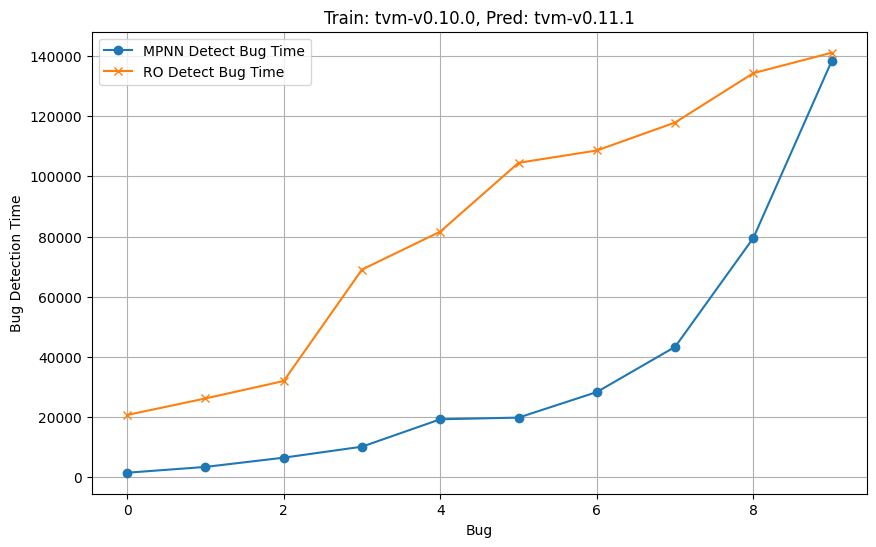

In [27]:
average_MPNN_detect_bug_time = []
average_RO_detect_bug_time = []
for i in range(len(MPNN_detect_bug_time_list)):
    average_MPNN_detect_bug_time.append(0)
    average_RO_detect_bug_time.append(0)
for i in range(len(MPNN_detect_bug_time_list)):
    for j in range(len(MPNN_detect_bug_time_list_total)):
        average_MPNN_detect_bug_time[i] += MPNN_detect_bug_time_list_total[j][i]
        average_RO_detect_bug_time[i] += RO_detect_bug_time_list_total[j][i]
for i in range(len(MPNN_detect_bug_time_list)):
    average_MPNN_detect_bug_time[i] = average_MPNN_detect_bug_time[i] / len(MPNN_detect_bug_time_list_total)
    average_RO_detect_bug_time[i] = average_RO_detect_bug_time[i] / len(MPNN_detect_bug_time_list_total)


# 创建图表
plt.figure(figsize=(10, 6))

# 绘制 MPNN_detect_bug_time_list
plt.plot(average_MPNN_detect_bug_time, label='MPNN Detect Bug Time', marker='o')

# 绘制 RO_detect_bug_time_list
plt.plot(average_RO_detect_bug_time, label='RO Detect Bug Time', marker='x')

# 添加标题和标签
plt.title('Train: tvm-v0.10.0, Pred: tvm-v0.11.1')
plt.xlabel('Bug')
plt.ylabel('Bug Detection Time')

# 添加图例
plt.legend()

# 显示图表
plt.grid(True)
plt.show()

In [28]:
import pickle
with open("mpnn-tvm-v0.11.1-testdata_0_11.pkl", 'wb') as file:
    pickle.dump(average_MPNN_detect_bug_time, file)